In [45]:
#imports
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import time
import pandas as pd
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import seaborn as sns
from sklearn.decomposition import PCA
from make_models import get_MRI_CVAE_3D
from tqdm import tqdm
import tensorflow as tf

In [47]:
pwd

'/mmfs1/data/bergerar/BC-MRI-ADHD/Code'

In [3]:
#load data
stuff = np.load('../Assets/brain_array-440.npz')
print(list(stuff.keys()))

data = stuff['data']
control = stuff['controls']
patients = stuff['patients']
n = data.shape[0]
#print(data.shape)
#data[patients,:,:,:].shape
#data[patients].shape

data_patients = data[patients,:,:,:]
data_controls = data[control,:,:,:]

print(data_patients.shape)
print(data_controls.shape)

['data', 'controls', 'patients']
(179, 64, 64, 64)
(261, 64, 64, 64)


In [4]:
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1,
                    disentangle=False,
                    gamma=1,
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)

In [52]:
cvae.load_weights('../Assets/tf_weights_10000_AB/tf_weightsAB')

In [6]:
data_patients.shape

(179, 64, 64, 64)

In [7]:
def get_reconstruction(data_in,adhd = True):

    z = z_encoder.predict(data_in)[0] # mu,std,sample
    s = s_encoder.predict(data_in)[0]

    if adhd==True:
        l = np.hstack((z,s))
    else:
        l = np.hstack((z,np.zeros(s.shape)))

    recon = cvae_decoder(l)[:,:,:,:,0]
    return recon

In [8]:
%%time
recon_patients = get_reconstruction(data_patients,adhd = True)
recon_controls = get_reconstruction(data_controls,adhd = False)


CPU times: user 1min 46s, sys: 22.8 s, total: 2min 9s
Wall time: 41.2 s


In [53]:
recon_patients.shape

TensorShape([179, 64, 64, 64])

In [26]:
# reconstructions = cvae_decoder.predict(np.hstack((background_features_adhd, salient_features_adhd)))

In [27]:
# reconstructions = reconstructions[:,:,:,:,0]

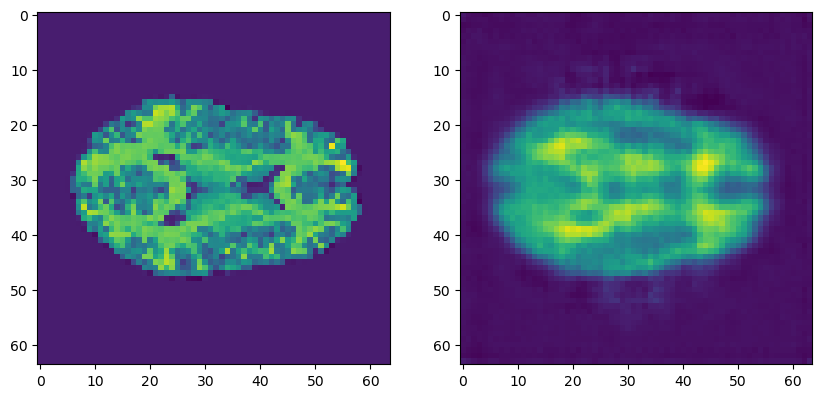

In [36]:
s = 0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

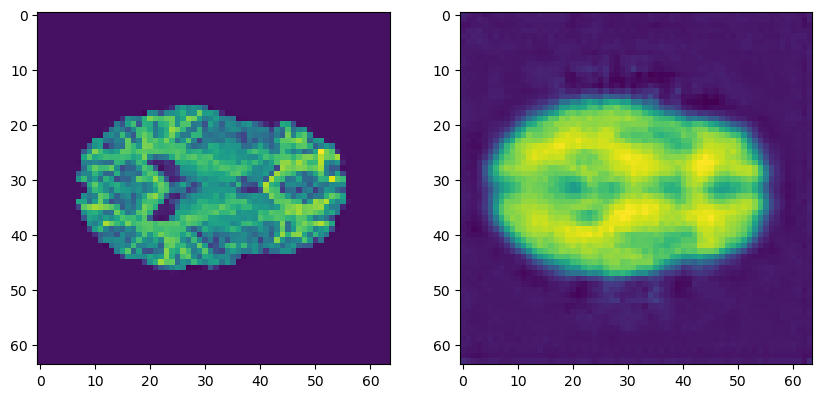

In [37]:
s = 1
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

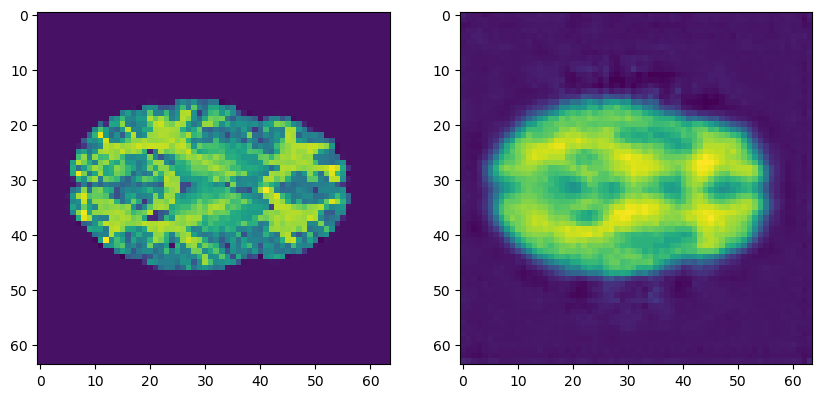

In [42]:
s = 2
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

In [ ]:
# MSE = (input-prediction)^2
# ^ average across the image
# should have one value per subject

In [78]:
#MSE

SE = ((data_patients[0,:,:,:] - recon_patients[0,:,:,:])**2)
print(SE)
#MSE = np.mean(SE)

# lst = list(range(0,179+1))
# for s in lst:


tf.Tensor(
[[[1.60808780e-03 6.31369185e-04 2.89709376e-08 ... 6.95726067e-06
   1.55770231e-05 1.76013215e-03]
  [4.98480862e-04 2.13484691e-05 1.91502215e-04 ... 1.90599003e-05
   7.45515063e-05 2.12849045e-04]
  [1.35083101e-04 9.62331069e-06 1.48350780e-04 ... 5.98151128e-05
   4.36723858e-05 6.26803492e-04]
  ...
  [2.28732133e-05 3.35939467e-06 4.48872539e-04 ... 4.26795632e-05
   4.64939221e-04 1.72025575e-05]
  [4.63201650e-06 1.70445972e-04 4.57600254e-04 ... 3.59084719e-04
   6.11774332e-04 9.53076305e-05]
  [1.07850612e-03 1.94904380e-04 1.19416086e-08 ... 1.04338753e-04
   1.35405605e-06 1.01982802e-03]]

 [[7.36831920e-04 6.55518379e-04 7.04641643e-05 ... 3.53143805e-05
   1.80312072e-05 1.35555235e-03]
  [7.82244315e-05 8.39635686e-05 3.09239113e-05 ... 1.50348103e-04
   8.08181721e-05 5.95728816e-05]
  [1.03900089e-08 3.93448463e-05 3.63157829e-04 ... 2.77245766e-04
   3.36584606e-04 1.32635018e-04]
  ...
  [2.16454118e-05 2.38782421e-04 9.18011210e-05 ... 3.07717477e-04

In [76]:
lst = list(range(0,178+1))
for s in lst:
    SE = ((data_patients[s,:,:,:] - recon_patients[s,:,:,:])**2)
    MSE = np.mean(SE)
    print(f'MSE{s} = {MSE}')

SyntaxError: cannot assign to f-string expression (<ipython-input-76-92111943c3ff>, line 5)

NameError: name 'MSE20' is not defined

In [25]:
# latent vectors
background_features_adhd = z_encoder.predict(data_patients)[0] # returns mean,std and sample of latent vectors, we take mean here
salient_features_adhd = s_encoder.predict(data_patients)[0]

In [16]:
s = 0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])